<a href="https://colab.research.google.com/github/7-4-7/Bert-Scratch/blob/main/Bert_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Objectives
- Understand Masked Language Modelling implimentation
- Understand and implement Bert Model
- Fine-Tune a actual bert model

# Phase - 1

- Prepare dataset - stable diffusion prompts
- Prepare model architecture
- Model to be trained on masked language modelling technique

In [1]:
import pandas as pd

splits = {'train': 'data/train.parquet', 'test': 'data/eval.parquet'}
df = pd.read_parquet("hf://datasets/Gustavosta/Stable-Diffusion-Prompts/" + splits["train"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
df

Prompt
0      realistic car 3 d render sci - fi car and sci ...
1      a comic potrait of a female necromamcer with b...
2      steampunk market interior, colorful, 3 d scene...
3      “A portrait of a cyborg in a golden suit, D&D ...
4      A full portrait of a beautiful post apocalypti...
...                                                  ...
73713  ismail inceoglu epic oil on canvas painting of...
73714  eating crayons and being reborn in the loving ...
73715  ilya kuvshinov with long hair, sky blue hair, ...
73716  cyberpunk woman with green hair wearing futuri...
73717  zulu cyborg, male, green eyes, red diodes, sci...

[73718 rows x 1 columns]

## Importing Key Libraries

In [5]:
!pip install -q torchvista # Later visualization of architecture

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.2 MB/s eta 0:00:00


In [6]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

from torchvista import trace_model

from transformers import BertTokenizer # Tokenizer

import pandas as pd
from tqdm import tqdm

torch.__version__

'2.6.0+cu124'

In [10]:
text = df['Prompt'][0]

In [11]:
text

'realistic car 3 d render sci - fi car and sci - fi robotic factory structure in the coronation of napoleon painting and digital billboard with point cloud in the middle, unreal engine 5, keyshot, octane, artstation trending, ultra high detail, ultra realistic, cinematic, 8 k, 1 6 k, in style of zaha hadid, in style of nanospace michael menzelincev, in style of lee souder, in plastic, dark atmosphere, tilt shift, depth of field,'

## Setting up custom dataset class
Scope : <br>
1. Create a custom dataset class that returns data in a format needed for masked language pretraining objective
2. `Tokenizer` - Identifies tokens -> Converts them to ids -> Adds special tokens
3. `seq_len` - Maximum number of tokens allowed per sequence [ including special tokens ] -> If greater -> Truncate else -> Pad
4. `input_ids` - Token's id in vocabulary
5. `attn_mask` - Contains boolean values, 1 indicates the token is allowed to be used in calulation of attention score. 0 indicates the vice versa. Since in some sequences we have added external tokens i.e padding to reach to a common seq len, this neednot to be used in further processing.
6. While masking the dataset following things need to kept in mind : <br>
  1. Each `token*` has `15% probability` of getting masked
  2. Token* must not be special token
  3. If a token* has been marked for masked <br>
    1. Each `marked token` has `80% probability of getting masked`, mask them first
    2. Each of the `remaining marked tokens` has `10% chances of getting replaced by a random token`* in vocabulary, replace them<br>
      1. Token mustn't be a special token
    3. Each of the `remaining marked tokens` have `10% chances of retention`

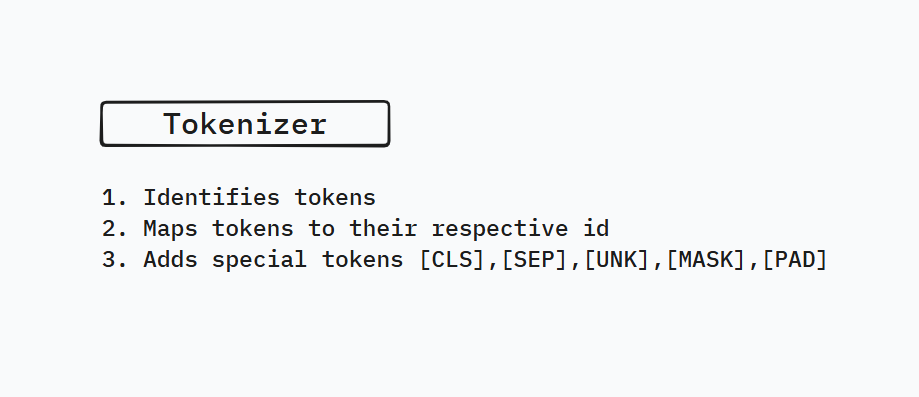

In [12]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [33]:
prompts = df['Prompt'].to_list()[:10000]

In [47]:
256//2

128

In [48]:
encoded = tokenizer(
    prompts,
    padding = 'max_length',
    truncation = True,
    max_length = 128,
    return_tensors ='pt',
)

In [49]:
encoded # Dictionary like

{'input_ids': tensor([[  101, 12689,  2482,  ...,     0,     0,     0],
        [  101,  1037,  5021,  ...,     0,     0,     0],
        [  101,  5492, 14289,  ...,     0,     0,     0],
        ...,
        [  101, 28774, 26261,  ...,     0,     0,     0],
        [  101,  6851,  3617,  ...,     0,     0,     0],
        [  101, 21014,  6533,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [50]:
encoded['input_ids'].shape # number of prompts x seq_length

torch.Size([10000, 128])

In [61]:
encoded['input_ids'][379]

tensor([  101, 25312, 25572, 28931,  9293,  1010, 26872,  8072,  1010,  1999,
         1996,  2806,  1997,  6175,  2002, 13668,  6582,  3102,  2937, 25540,
        10556, 17311,  2063,  2038, 10179, 15544,  7677,  3683, 25209,  2850,
         1010,  1017,  1040, 17552,  1010,  2840, 12516,  9874,  2075,  1010,
         1022,  1047,  1010, 13323,  7231, 17552,  1010,  6302, 22852,  6553,
         1010,  3872, 12412,  7497,  6187, 19966,  6558,  1010, 16524,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [66]:
ids = encoded['input_ids'][0]
ids

tensor([  101, 12689,  2482,  1017,  1040, 17552, 16596,  1011, 10882,  2482,
         1998, 16596,  1011, 10882, 20478,  4713,  3252,  1999,  1996, 12773,
         1997,  8891,  4169,  1998,  3617,  4908,  2007,  2391,  6112,  1999,
         1996,  2690,  1010,  4895, 22852,  3194,  1019,  1010,  6309, 12326,
         1010, 13323,  7231,  1010,  2840, 12516,  9874,  2075,  1010, 11087,
         2152,  6987,  1010, 11087, 12689,  1010, 21014,  1010,  1022,  1047,
         1010,  1015,  1020,  1047,  1010,  1999,  2806,  1997, 23564,  3270,
         2018,  3593,  1010,  1999,  2806,  1997, 28991, 23058,  2745,  2273,
        12638,  2378,  3401,  2615,  1010,  1999,  2806,  1997,  3389,  2061,
        29190,  1010,  1999,  6081,  1010,  2601,  7224,  1010, 17010,  5670,
         1010,  5995,  1997,  2492,  1010,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [72]:
special_tokens_list = tokenizer.all_special_ids
special_tokens_list
id = ids[0]

ids in special_tokens_list

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
class MLMPrompts(Dataset):
    def __init__(self, df, seq_len = 128, stop_idx = 40_000):
        """Given a list of prompts, generate input, target pair"""

        self.prompts = df['Prompt'].to_list()[:stop_idx]
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.seq_len = seq_len
        self.tokenized_prompts = self._get_data()

    def _get_data(self):
        pairs = []

        #---------------------------------------------------------------
        # Perform tokenization

        encoded = self.tokenizer(  # Dictionary like obj (*) containing input_ids, token_type_ids, attn_mask
            self.prompts,
            padding = 'max_length',
            truncation = True,
            max_length = self.seq_len,
            return_tensor ='pt'
        )

        #---------------------------------------------------------------
        # encoded : contains special token as well as padding tokens
        # Next step : Take input ids, mask them and create labels

        input_ids = encoded['input_ids'] # len(df) x 128
        masked_ids, labels = self.apply_mask(input_ids)

    def apply_mask(self, input_ids):
      for i in range(input_ids.shape[0]):
        labels = input_ids.clone()
        p_matrix = torch.full(input_ids.shape, 0.15)

        # Update p_matrix to 0 probability for special tokens
        special_token_mask = self.get_special_token_mask(i).bool()
        p_matrix.masked_fill_(special_token_mask, value = 0.0)





    def get_special_token_mask(self, ids):
        mask = []
        for id in ids:
            if self.check_special_index(id):
                mask.append[1]
            else:
                mask.append[0]

    def check_special_index(self, id):
        special_id_list = self.tokenizer.all_special_ids
        if id in special_id_list
            return True
        return False







        #---------------------------------------------------------------
        # Loop over all the prompts
        for prompt in self.prompts:
            # For each prompt get it's tokenized version
            encoded = self.tokenizer(prompt,
                                   padding="max_length",
                                   truncation=True,
                                   max_length=self.seq_len,
                                   return_tensors='pt')

            # Convert them to token ids and add special tokens[By default]
            token_ids = encoded.input_ids.squeeze(0)  # Remove batch dimension
            attention_mask = encoded.attention_mask.squeeze(0)  # Remove batch dimension

            # Apply Mask
            masked_ids, target_ids = self._apply_mask(token_ids)

            # Store masked data and correct outputs
            temp_dict = {
                'masked_ids': masked_ids,
                'target_ids': target_ids,
                'attn_mask': attention_mask,
            }
            pairs.append(temp_dict)
        return pairs

    def _apply_mask(self, token_ids):
        """ Perform masking according to the rule :
            1. Each token has 15% chance that it is gonna get masked, Loss computed on those only
            2. If a token has been marked to get masked :
               80% chances are there that it will get masked
               10% chances are there that it will get substituted by a random token in vocab [ no special token ]
               10% chances are there that it will remain unchanged
        """
        labels = token_ids.clone()  # Deep Copy

        # Each token has 15% chance of being masked
        p_matrix = torch.full(labels.shape, 0.15)  # 15% masking

        # Avoid masking special tokens
        special_token_mask = torch.tensor([
            self.tokenizer.get_special_tokens_mask([token_id.item()], already_has_special_tokens=True)[0]
            for token_id in labels  # Fixed: removed [0] indexing
        ], dtype=torch.bool)

        # Update the p_matrix : Update the probabilities of above special tokens to 0
        p_matrix.masked_fill_(special_token_mask, value=0.0)

        # Get masked indices : Indices marked to be masked
        masked_indices = torch.bernoulli(p_matrix).bool()

        # Update labels : Only contain masked tokens (set non-masked to -100)
        labels[~masked_indices] = -100

        # 80% of tokens marked to be mask -> [MASK]
        indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
        token_ids[indices_replaced] = self.tokenizer.convert_tokens_to_ids(self.tokenizer.mask_token)

        # 10% of remaining masked tokens (not 10% of all) with random words
        # Fixed: should be 0.5 probability on remaining tokens to get 10% overall
        indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced

        # Generate random tokens excluding special tokens
        vocab_size = len(self.tokenizer.vocab)
        special_tokens = set(self.tokenizer.all_special_ids)

        # Create a list of valid token ids (excluding special tokens)
        valid_token_ids = [i for i in range(vocab_size) if i not in special_tokens]

        # Sample random tokens from valid token ids
        num_random_positions = indices_random.sum().item()
        if num_random_positions > 0:
            random_token_indices = torch.randint(0, len(valid_token_ids), (num_random_positions,))
            random_tokens = torch.tensor([valid_token_ids[i] for i in random_token_indices])
            token_ids[indices_random] = random_tokens

        # Remaining 10% of masked tokens stay unchanged (this happens automatically)

        return token_ids, labels

    def __len__(self):
        return len(self.tokenized_prompts)

    def __getitem__(self, idx):
        return self.tokenized_prompts[idx]

In [ ]:
bool(0.15)

True

In [ ]:
ds = MLMPrompts(df, 128, stop_idx=10)

In [ ]:
ds.__getitem__(6)

{'masked_ids': tensor([  101,  6335,  3148, 13970, 15088, 10606,  4492,  2007,  2146,  3712,
          2630,  2606,  1010,  2751,  2159,  1010,  2658,  3617,  4169,  1010,
          4145,  2396,  1010, 18880,   103,  3194,   103,  1010,  1022,  1047,
          1010,   103,  1010,   103,  4135,  2361,  1010, 17255,   103,  7166,
         15928,  2015,  1999,  1996,  4281,  1010,   103,  2011,  6754, 21766,
          2102, 15449,  1010, 14255,  9048,   103,  2396,  1010, 12022,  4478,
         23333,  1010, 10930,   103, 28412, 25933,  3630,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

## Initializing Dataloader

In [ ]:
# Hyperparameters
seq_len = 128
stop_idx = 300

batch_size = 16

In [ ]:
dataset = MLMPrompts(
    df = df,
    seq_len = seq_len,
    stop_idx = stop_idx,
)

# 80-20 split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(
    dataset=train_ds,
    batch_size = batch_size,
    shuffle = True,
)

test_loader = DataLoader(
    dataset = test_ds,
    batch_size = batch_size,
    shuffle = False,
)

In [ ]:
len(train_loader), len(test_loader)

(15, 4)

In [ ]:
2000*16 + 500*16


40000

In [ ]:
next(iter(train_loader))

{'masked_ids': tensor([[  101, 15540,  6906,  ...,     0,     0,     0],
         [  101, 26502,  6851,  ...,     0,     0,     0],
         [  101, 14231,   999,  ...,     0,     0,     0],
         ...,
         [  101, 24111, 16543,  ...,     0,     0,     0],
         [  101,  2019, 14614,  ...,     0,     0,     0],
         [  101,  1037,  3376,  ...,     0,     0,     0]]),
 'target_ids': tensor([[-100, -100, -100,  ..., -100, -100, -100],
         [-100, -100, -100,  ..., -100, -100, -100],
         [-100, -100, -100,  ..., -100, -100, -100],
         ...,
         [-100, -100, -100,  ..., -100, -100, -100],
         [-100, -100, -100,  ..., -100, -100, -100],
         [-100, -100, -100,  ..., -100, -100, -100]]),
 'attn_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}

## Bert Model Implementation

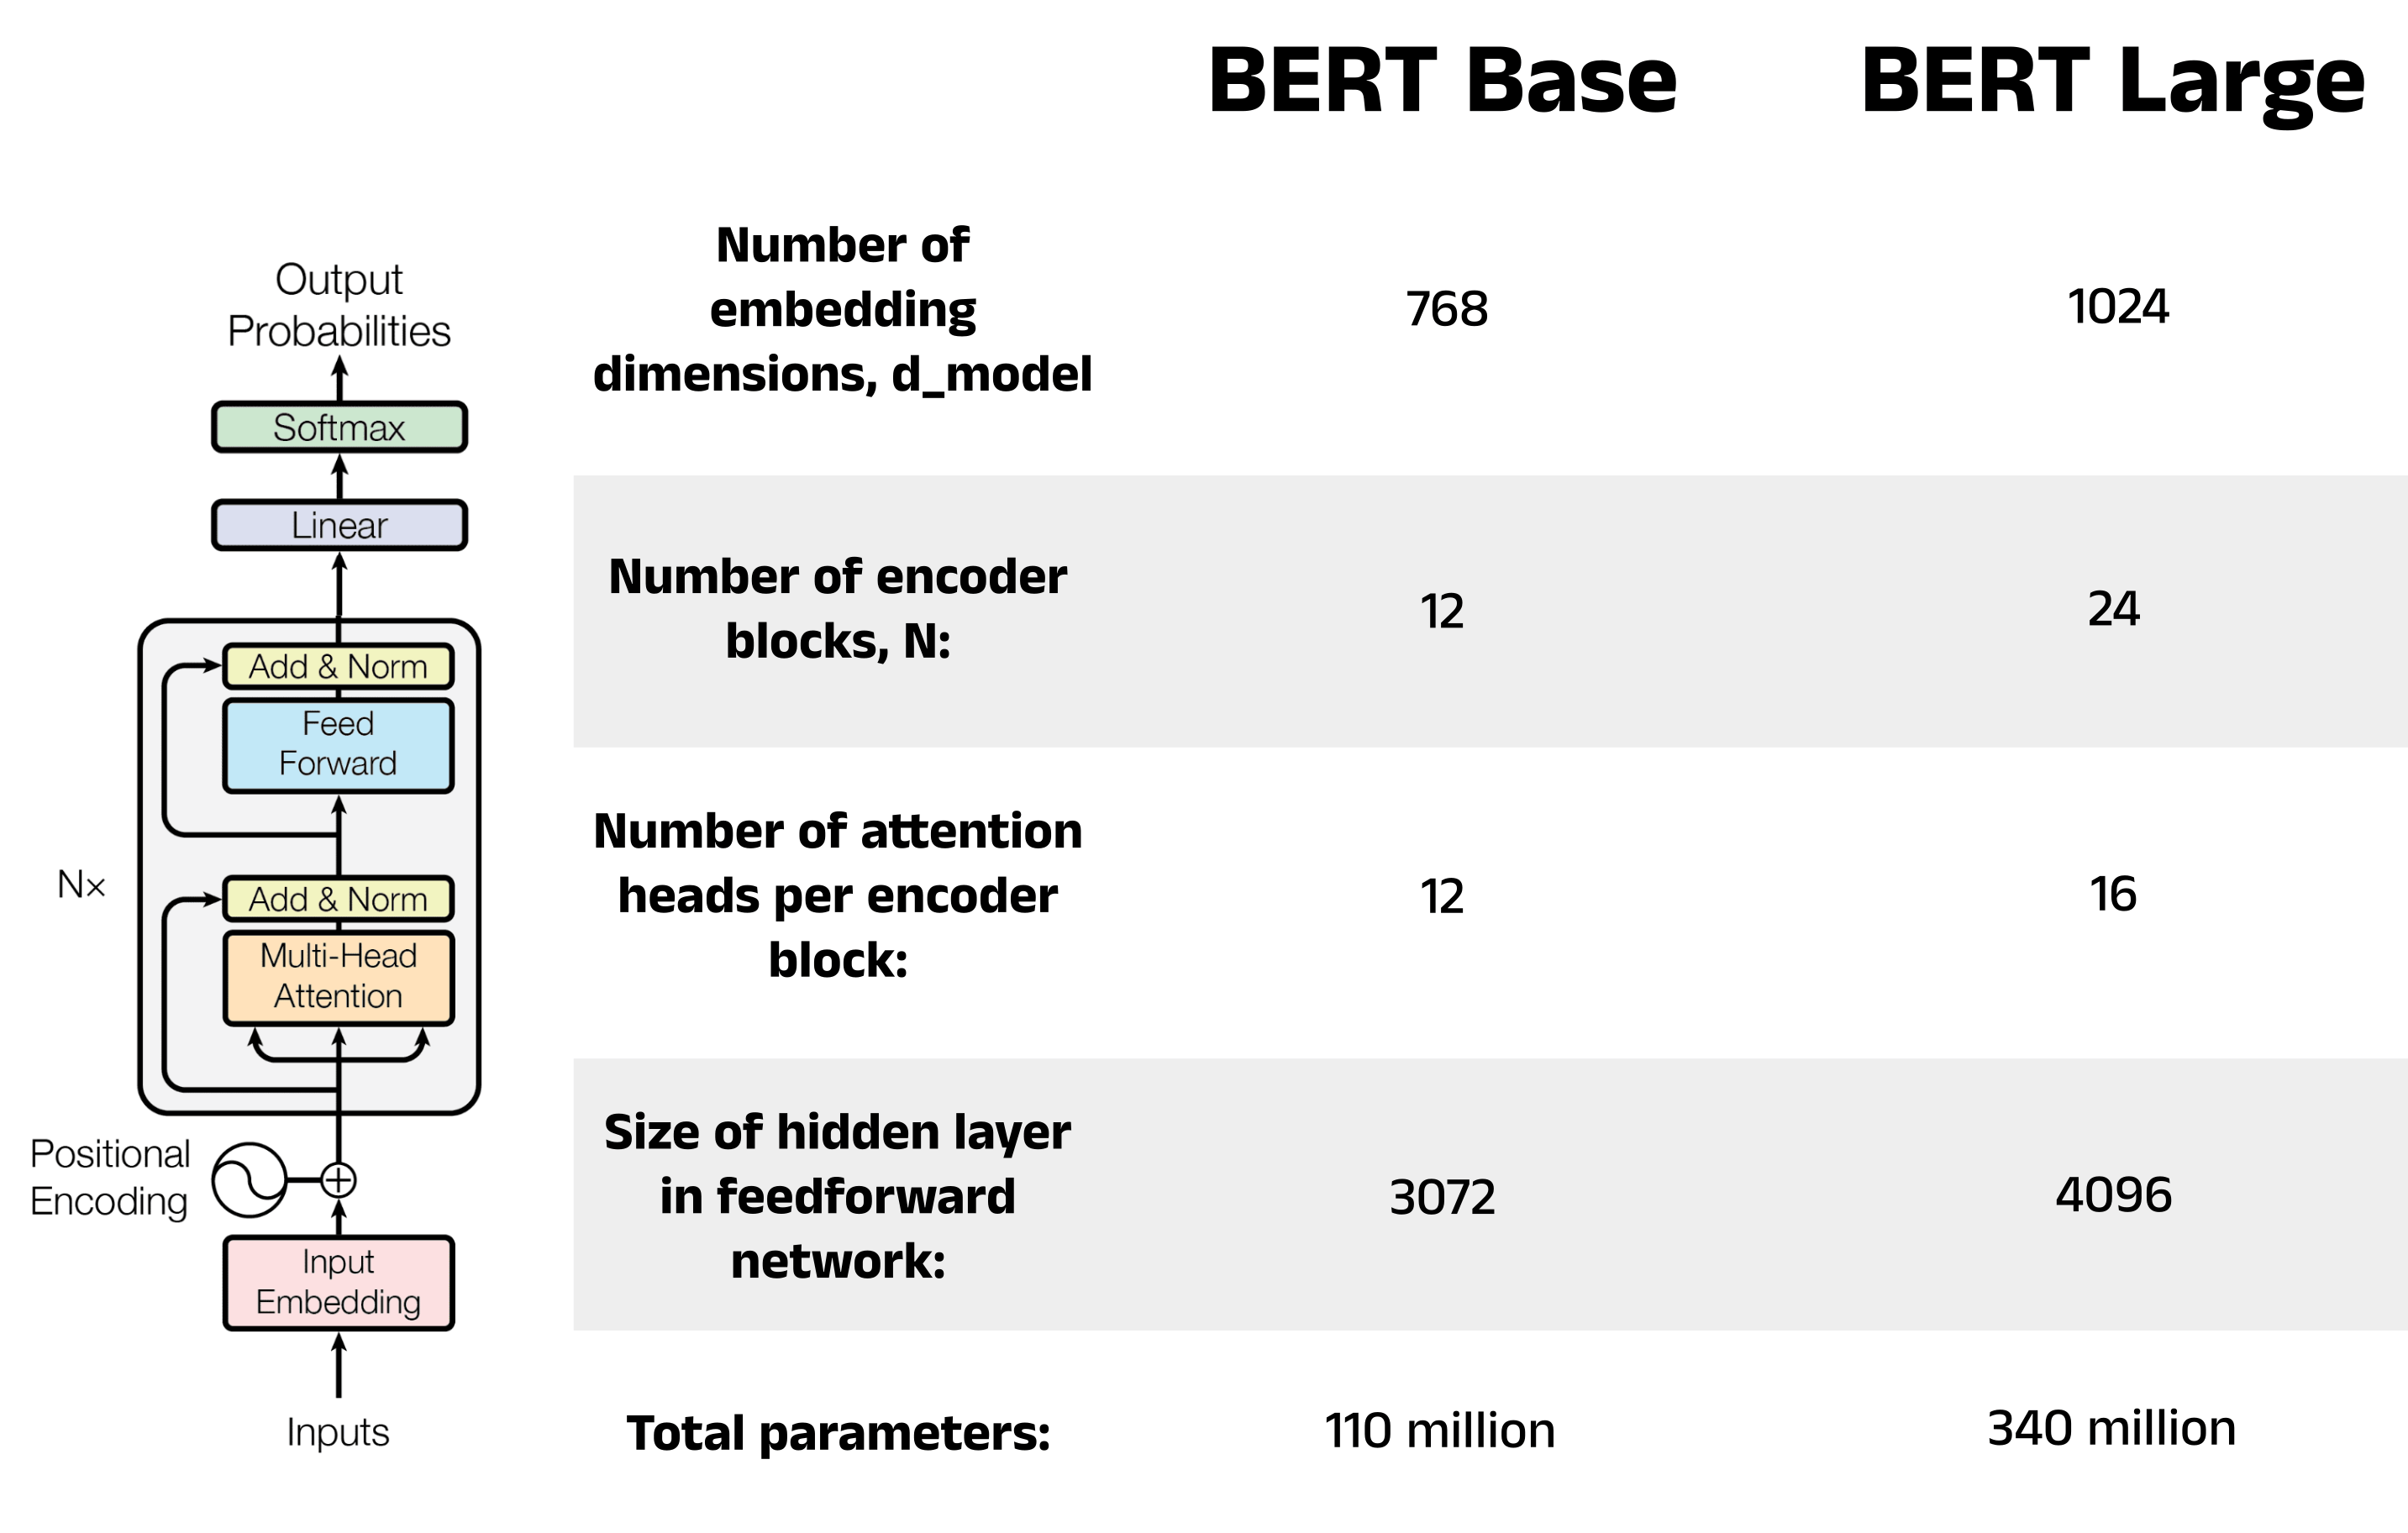

In [ ]:
class BertEmbeddings(nn.Module):
  """ Converts tokens into positional aware embeddings """

  def __init__(self, vocab_size, d_model, seq_len):
    super().__init__()

    # Initialise a learnable look-up table for word embeddings
    self.word_emb = nn.Embedding(vocab_size, d_model)

    # Initialise a learnable look-up table for positional embeddings
    self.position_emb = nn.Embedding(seq_len, d_model)

    # Layer Norm and dropout
    self.layer_norm = nn.LayerNorm(d_model, eps = 1e-12)
    self.dropout = nn.Dropout(0.1)

  def forward(self, input_ids):
    seq_len = input_ids.size(1) # Same for all input_ids
    position_ids = torch.arange(seq_len, dtype = torch.long, device = input_ids.device)
    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

    word_emb = self.word_emb(input_ids)
    p_emb = self.position_emb(position_ids)

    emb = word_emb + p_emb

    emb = self.layer_norm(emb)
    emb = self.dropout(emb)

    return emb

In [ ]:
# Sanity Check

emb_model = BertEmbeddings(30_000,512,128)
print(emb_model,'\n')

dummy_input = torch.randint(0,30000, (2, 10))

print(emb_model(dummy_input), emb_model(dummy_input).shape)

BertEmbeddings(
  (word_emb): Embedding(30000, 512)
  (position_emb): Embedding(128, 512)
  (layer_norm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
) 

tensor([[[-0.0000e+00,  1.0218e+00,  0.0000e+00,  ...,  6.1161e-01,
          -2.6255e-02, -1.0154e+00],
         [ 9.4953e-01, -8.0801e-03, -0.0000e+00,  ...,  8.5734e-01,
          -7.1994e-01,  8.2138e-01],
         [ 3.2128e-01, -5.0037e-01, -1.1210e+00,  ..., -7.0625e-01,
           1.1457e+00,  4.5904e-01],
         ...,
         [-1.4874e+00,  7.9384e-01, -7.0375e-01,  ..., -9.1105e-02,
          -8.5207e-02,  0.0000e+00],
         [-7.2534e-01, -7.5674e-01,  8.2272e-01,  ..., -4.8965e-01,
           6.8567e-01,  4.6925e-01],
         [ 1.8013e-01, -2.9384e+00, -7.7810e-01,  ..., -8.4182e-01,
          -7.6124e-01, -4.1679e-01]],

        [[ 7.5268e-01,  1.0952e+00,  1.9804e-01,  ...,  5.3953e-01,
           2.8967e-01,  0.0000e+00],
         [ 0.0000e+00, -8.4684e-01, -1.263

In [ ]:
trace_model(emb_model, dummy_input)

In [ ]:
class BertSingleEncoderBlock(nn.Module):
  def __init__(self, d_model = 512, num_heads = 2, intermediate_size = 2048, dropout = 0.1):
    super().__init__()
    self.d_model = d_model

    self.mha = nn.MultiheadAttention(embed_dim=d_model, num_heads = num_heads, dropout = dropout)
    self.layer_norm_1 = nn.LayerNorm(d_model)
    self.layer_norm_2 = nn.LayerNorm(d_model)

    self.ff_network = nn.Sequential(
        nn.Linear(d_model, intermediate_size),
        nn.GELU(),
        nn.Linear(intermediate_size, d_model),
        nn.Dropout(dropout),
    )

  def forward(self, x, attn_mask = None):
    # X -> Batch_Size x seq_len x d_model

    x = x.transpose(0,1)
    # X -> seq_len x batch_size x d_model

    attn_output, _ = self.mha(x, x, x, key_padding_mask=attn_mask)

    # Skip Connection 1 [ Add and norm ]
    x = x + attn_output
    x = self.layer_norm_1(x)

    # FF network
    ff_output = self.ff_network(x)

    # Skip Connection 2 [Add and norm]
    x = x + ff_output
    x = self.layer_norm_2(x)

    x = x.transpose(0,1)
    return x


In [ ]:
# Sanity Check
BertSingleEncoderBlock()

BertSingleEncoderBlock(
  (mha): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (layer_norm_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (layer_norm_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (ff_network): Sequential(
    (0): Linear(in_features=512, out_features=2048, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=2048, out_features=512, bias=True)
    (3): Dropout(p=0.1, inplace=False)
  )
)

In [ ]:
class MiniBert(nn.Module):
  def __init__(self, vocab_size = 30_000, d_model = 512, seq_len = 128, num_heads = 8, num_layers = 4, intermediate_size = 2048, dropout = 0.1):
    super().__init__()

    # Embeddings - position emb + word emb
    self.embeddings = BertEmbeddings(vocab_size, d_model, seq_len)

    # Encoder layers
    self.encoder_layers = nn.ModuleList(
        [BertSingleEncoderBlock(d_model, num_heads, intermediate_size, dropout) for _ in range(num_layers)])

    # Dense Layer
    self.mlm_head = nn.Linear(d_model, vocab_size)

  def forward(self, input_ids, attn_mask = None):
    x = self.embeddings(input_ids)
    for layer in self.encoder_layers:
      x = layer(x, attn_mask = attn_mask)
    return self.mlm_head(x)


In [ ]:
# Sanity Check
bm = MiniBert()
print(bm)

# Total parameters
total_params = sum(p.numel() for p in bm.parameters())
print(f"Total parameters: {total_params:,}")

dummy_input = torch.randint(0, 30000, (2, 128))

# Forward pass
output = bm(dummy_input)

print(f"Output shape: {output.shape}")

MiniBert(
  (embeddings): BertEmbeddings(
    (word_emb): Embedding(30000, 512)
    (position_emb): Embedding(128, 512)
    (layer_norm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layers): ModuleList(
    (0-3): 4 x BertSingleEncoderBlock(
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (layer_norm_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (layer_norm_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ff_network): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=2048, out_features=512, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (mlm_head): Linear(in_features=512, out_features=30000, bias=True)
)
Total parameters: 43,426,096
Output shape: torch.Size([2, 128

In [ ]:
trace_model(bm, dummy_input)

## Traning

In [ ]:
EPOCHS = 5

vocab_size = 30_000
d_model = 512
seq_len = 128
num_heads = 4
num_layers = 6
intermediate_size = 2048
dropout = 0.1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = MiniBert(vocab_size, d_model, seq_len, num_heads, num_layers, intermediate_size, dropout).to(device)

In [ ]:
lengths = [len(tokenizer.encode(t)) for t in df['Prompt'][:30_000]]
import numpy as np
np.percentile(lengths, [50, 75, 90, 95, 99])


array([ 61.,  76.,  87., 100., 138.])

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
tokens = tokenzier.tokenize(text)

In [ ]:
len(tokens)

104

In [ ]:
token_ids = tokenzier.convert_tokens_to_ids(tokens)
token_ids

[3793]

In [ ]:
sentence = 'At future I want to qualify GATE DA 2026 and in long term I want to get in Amazon or Microsoft as applied scientict or principle scientist'

In [ ]:
encodings = tokenzier(
    df["Prompt"].tolist()[:30_000],
    truncation=True,
    padding=True,
    max_length=64,
    return_tensors="pt"
)


In [ ]:
encodings.token_type_ids.shape

torch.Size([30000, 64])

In [ ]:
class MLMPrompts(Dataset):
    """Custom dataset class that prepares the data for MLM training"""

    def __init__(self, df, seq_len, stop_idx: int = 20_000):
        """
        Args:
            df: Pandas DataFrame with column 'Prompt'
            seq_len: Max sequence length
            stop_idx: Limit dataset size
        """
        self.prompts = df['Prompt'].to_list()[:stop_idx]
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.seq_len = seq_len
        self.tokenized_prompts = self._get_data()

    def _get_data(self):
        """Return list of dicts: {masked_ids, target_ids, attn_mask}"""

        pairs = []
        for prompt in self.prompts:

            # Tokenize
            encoded = self.tokenizer(
                prompt,
                padding="max_length",
                truncation=True,
                max_length=self.seq_len,
                return_tensors='pt'
            )

            # Remove batch dimension from tokenizer output
            token_ids = encoded.input_ids[0]         # shape: (seq_len,)
            attn_mask = encoded.attention_mask[0]    # shape: (seq_len,)

            # Apply Masking
            masked_ids, target_ids = self._apply_mask(token_ids)

            pairs.append({
                'masked_ids': masked_ids,
                'target_ids': target_ids,
                'attn_mask': attn_mask
            })

        return pairs

    def _apply_mask(self, token_ids):
        """
        Apply BERT-style 15% masking with 80/10/10 rule
        token_ids: Tensor of shape (seq_len,)
        Returns:
            masked_ids: Tensor (seq_len,) with some tokens replaced/masked
            target_ids: Tensor (seq_len,) with original tokens at masked positions, else -100
        """

        labels = token_ids.clone()

        # 15% probability for masking
        p_matrix = torch.full(labels.shape, 0.15)

        # Avoid masking special tokens ([CLS], [SEP], [PAD])
        special_token_mask = torch.tensor(
            self.tokenizer.get_special_tokens_mask(
                token_ids.tolist(),
                already_has_special_tokens=True
            ),
            dtype=torch.bool
        )
        p_matrix.masked_fill_(special_token_mask, value=0.0)

        # Select positions to mask
        masked_indices = torch.bernoulli(p_matrix).bool()
        labels[~masked_indices] = -100  # -100 ignored by loss

        # 80% of masked → [MASK] token
        indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
        token_ids[indices_replaced] = self.tokenizer.convert_tokens_to_ids(self.tokenizer.mask_token)

        # 10% of masked → random token
        indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
        random_words = torch.randint(len(self.tokenizer), labels.shape, dtype=torch.long)
        token_ids[indices_random] = random_words[indices_random]

        # Remaining 10% stay the same

        return token_ids, labels

    def __len__(self):
        return len(self.tokenized_prompts)

    def __getitem__(self, idx):
        return self.tokenized_prompts[idx]
